# Server-side Compute with Rooki and `intake-esgf` 

Import what we will need for the demonstration.

In [1]:
import os

import intake_esgf
import matplotlib.pyplot as plt
from intake_esgf import ESGFCatalog

Before importing rooki, we need to signal which WPS deployment we will be using.

In [2]:
url = "https://esgf-node.ornl.gov/wps"
os.environ["ROOK_URL"] = url

from rooki import operators as ops

Because we are using the ORNL deployment, we will configure `intake-esgf` to only search for holdings we have there.

In [3]:
intake_esgf.conf.set(
    indices={
        "anl-dev": False,
        "ornl-dev": True,
    }
);

Now we search the ESGF holdings for temperature data for a few models, again specifying that the data be located at ORNL.

In [4]:
cat = ESGFCatalog().search(
    data_node="esgf-node.ornl.gov",  # <-- just data that is local to ORNL
    experiment_id="historical",
    variable_id="tas",
    member_id="r1i1p1f1",
    table_id="Amon",
    source_id=["MIROC6", "CESM2", "GISS-E2-1-G", "CMCC-ESM2"],
)

   Searching indices:   0%|          |0/1 [       ?index/s]

The catalog returns a lot of information about the datasets that were found, but we will use part of it to create a ID that rooki uses to load data.

In [5]:
def build_rooki_id(id_list):
    rooki_id = id_list[0]
    rooki_id = rooki_id.split("|")[0]  # remove the |esgf-node.ornl.gov
    rooki_id = f"css03_data.{rooki_id}" # prepend 
    return rooki_id


rooki_ids = cat.df.id.apply(build_rooki_id).to_list()
print(rooki_ids)

['css03_data.CMIP6.CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1.Amon.tas.gn.v20210114', 'css03_data.CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1i1p1f1.Amon.tas.gn.v20180827', 'css03_data.CMIP6.CMIP.NCAR.CESM2.historical.r1i1p1f1.Amon.tas.gn.v20190308', 'css03_data.CMIP6.CMIP.MIROC.MIROC6.historical.r1i1p1f1.Amon.tas.gn.v20181212']


Rooki arms us with operators (the `ops` namespace) that will run server-side that will subset and average the data for us. 

In [6]:
def europe_annual_temperature(rooki_id):
    workflow = ops.AverageByTime(
        ops.Subset(
            ops.Input("tas", [rooki_id]),
            time="1990-01-01/2000-01-01",
            area="-11,35,21,59",
        ),
        freq="year",
    )
    response = workflow.orchestrate()
    if not response.ok:
        raise ValueError(response)
    return response.datasets()[0]

This function encapsulates the interaction, we have only to loop over the `rooki_ids` and load the results in a dictionary.

In [7]:
dsd = {
    rooki_id.split(".")[4]: europe_annual_temperature(rooki_id)
    for rooki_id in rooki_ids
}
print(dsd.keys())

Metalink content-type detected.
Metalink content-type detected.
Metalink content-type detected.
Metalink content-type detected.
dict_keys(['CMCC-ESM2', 'GISS-E2-1-G', 'CESM2', 'MIROC6'])


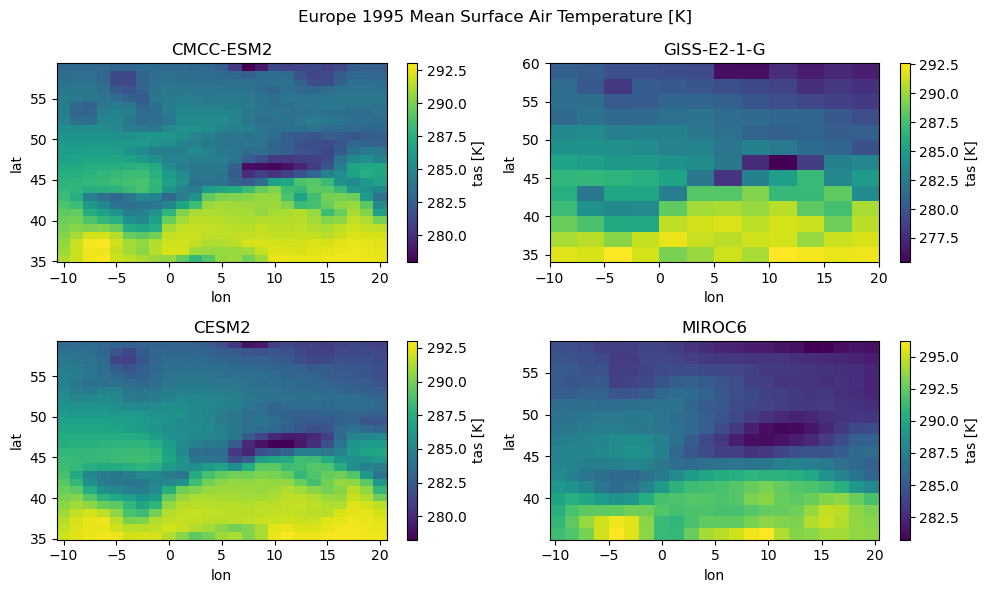

In [9]:
fig, axs = plt.subplots(figsize=(10,6),nrows=2, ncols=2, tight_layout=True)
for i, key in enumerate(dsd):
    ax = axs[i//2 , i % 2]
    dsd[key]["tas"].sel(time="1995-01-01").plot(ax=ax, cbar_kwargs={"label": "tas [K]"})
    ax.set_title(key)
    ax.set_xlabel("lon")
    ax.set_ylabel("lat")
fig.suptitle("Europe 1995 Mean Surface Air Temperature [K]");

# Key Points

- Great solution if a user tasks fits in the operators that rooki implements
- Minimizes data transfer by operating on the data where it is stored
- `intake-esgf` is used to form the IDs that rooki needs to locate data